# **Pairwise Sequence Alignment Demo**

# The Needleman-Wunsch algorithm

The Needleman-Wunsch algorithm finds the optimal *global* alignment (end-to-end) between two sequences.
It consists of the following steps:

1. Construct the grid
2. Choose a scoring system (here we use the original scoring system assigning a score $s$ of 1 to a match, a score $s$ of -1 to a mismatch, and a score $d$ of -1 to a gap/indel)
3. Fill in the scoring matrix $F$ (and construct the pointer matrix on the way)
4. Use the pointer matrix to perform a traceback to recover the optimal warping path

The scores in the scoring matrix $F$ are computed using the already existing scores in the left, top-left, and top cells:

$$
F(i,j)=\max
\begin{cases}
    F(i-1,j-1)+s(x_i,y_i),\\
    F(i-1,j)+d,\\
    F(i,j-1)+d.
\end{cases}
$$

The following image illustrates the scoring and pointer matrices.

<img src="nw-matrix.png" width="500" />

We can use the `make_align()` function from our `alignment` module to generate an `align()` function that performs the Needleman-Wunsch algorithm.

In [1]:
import alignment as aln

x = "GATTACA"
y = "CATACCCA"

align = aln.make_align(mode="global")
x_aln, y_aln, warp_path_x, warp_path_y, scoring_mat = align(seq_a=x, seq_b=y)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


We can also plot the alignment together with the scoring matrix:

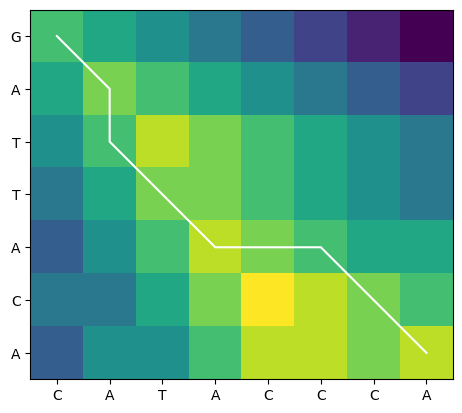

In [2]:
import matplotlib.pyplot as plt

plt.imshow(X=scoring_mat)
plt.plot(warp_path_y, warp_path_x, "w")
plt.xticks(ticks=range(len(y)), labels=y)
plt.yticks(ticks=range(len(x)), labels=x)
plt.show()

# The Smith-Waterman algorithm

The Smith-Waterman algorithm finds the optimal *local* alignment between two sequences.
It is a variation of the Needleman-Wunsch algorithm.

The three main differences are:

|                | Smith-Waterman algorithm                                | Needleman-Wunsch algorithm                                                 |
|----------------|---------------------------------------------------------|----------------------------------------------------------------------------|
| Initialization | First row/column = 0                                    | First row/column subject to gap penalty                                    |
| Scoring        | Negative scores are set to 0                            | Scores can be negative                                                     |
| Traceback      | Begin with the highest score, end when 0 is encountered | Begin with the cell at the lower right of the matrix, end at top left cell |

Again, with our `alignment` module, we can perform the local alignment between the sequences `GATACCA` and `NNNNNNNNNNGATTACANNNNNNNNGATNNNNNNNNN`.

align: Multiple (2) possible traceback starts
align: Choosing traceback start by random: [ 7 17]


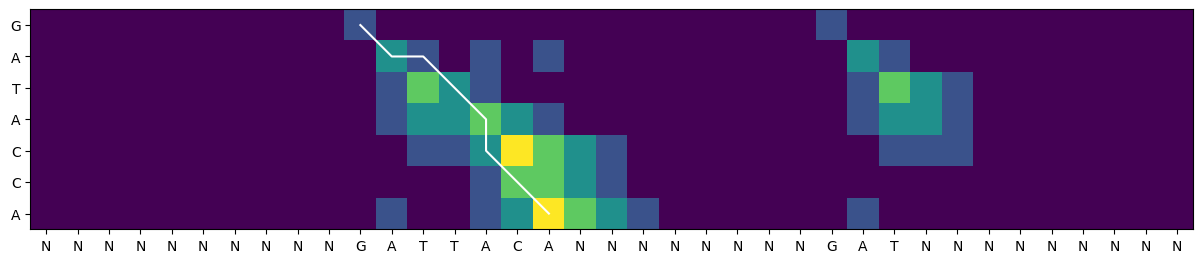

In [3]:
x = "GATACCA"
y = "NNNNNNNNNNGATTACANNNNNNNNGATNNNNNNNNN"

align = aln.make_align(mode="local")
x_aln, y_aln, warp_path_x, warp_path_y, scoring_mat = align(seq_a=x, seq_b=y)

plt.figure(figsize=[15, 8])
plt.imshow(X=scoring_mat)
plt.xticks(ticks=range(len(y)), labels=y)
plt.yticks(ticks=range(len(x)), labels=x)
plt.plot(warp_path_y, warp_path_x, "w")
plt.show()

# Read alignment

We can also simulate the alignment of many reads originating from e.g., a bulk DNA sequencing experiment.

First, we simulate the generation of a number of reads, by sampling  5 reads from the reference sequence `GATTTGGGGTTCAAAGCAGTATCGATCAAATAGTAAATCCATTTGTTCAACTCACAGTTTA`.

In [4]:
import random

reference_sequence = "GATTTGGGGTTCAAAGCAGTATCGATCAAATAGTAAATCCATTTGTTCAACTCACAGTTTA"

n_reads = 20
min_read_len = 15
max_read_len = 25

reads = []

while len(reads) < n_reads:
    range_acquired = False
    while not range_acquired:
        start_position = random.randrange(len(reference_sequence))
        end_position = random.randrange(len(reference_sequence))
        if start_position > end_position:
            continue
        range_len = end_position - start_position + 1
        if range_len < min_read_len or range_len > max_read_len:
            continue
        range_acquired = True
    read = reference_sequence[start_position : (end_position + 1)]
    reads.append(read)

print(reads)

['TAAATCCATTTGTTCAA', 'GTTCAAAGCAGTATCGATCAAATAG', 'GCAGTATCGATCAAATAGTAAATCC', 'TTGGGGTTCAAAGCAGTATCGA', 'CCATTTGTTCAACTCACAG', 'GCAGTATCGATCAAATAGTA', 'AAAGCAGTATCGATCAAATAGT', 'TAAATCCATTTGTTCAA', 'TTCAAAGCAGTATCGATCAAA', 'GGGGTTCAAAGCAGTAT', 'GTTCAAAGCAGTATCGATCAAAT', 'CATTTGTTCAACTCAC', 'ATAGTAAATCCATTTGTTCAACT', 'GGGGTTCAAAGCAGTA', 'TATCGATCAAATAGTAAATCCA', 'GGGGTTCAAAGCAGTAT', 'GGGGTTCAAAGCAGTATCGATCAA', 'AGTAAATCCATTTGTTCA', 'GTATCGATCAAATAGTA', 'GTAAATCCATTTGTTCAACT']


Next we add some noise to the sampled reads.

In [5]:
def add_noise(read: str, noiselessness: int = 4) -> (str, int):
    choices = ["A", "C", "G", "T"]
    n_noisy_bases = 0
    noisy_read = ""
    for base in read:
        if not random.randrange(noiselessness):
            noisy_read += random.choice(seq=[c for c in choices if c != base])
            n_noisy_bases += 1
        else:
            noisy_read += base
    return noisy_read, n_noisy_bases


noisy_reads = []
for read in reads:
    noisy_read, n_noisy_bases = add_noise(read=read, noiselessness=3)
    print(f"Added {n_noisy_bases:2} noisy base(s): {read:10s} -> {noisy_read:10s}")
    noisy_reads.append(noisy_read)

Added  7 noisy base(s): TAAATCCATTTGTTCAA -> TACCTCCATTGCCACAC
Added 11 noisy base(s): GTTCAAAGCAGTATCGATCAAATAG -> TACGAAAGCACGGTAGGTTAATTAG
Added 13 noisy base(s): GCAGTATCGATCAAATAGTAAATCC -> CCGGGACAGGTAAGGTAATAACCAC
Added  7 noisy base(s): TTGGGGTTCAAAGCAGTATCGA -> TTGGGGTGCTTAGGGGTATGGC
Added  6 noisy base(s): CCATTTGTTCAACTCACAG -> GCATTCCTTCAAAACACGG
Added  7 noisy base(s): GCAGTATCGATCAAATAGTA -> CCAGTATCAGTCAACTCTTT
Added  5 noisy base(s): AAAGCAGTATCGATCAAATAGT -> AACCCAGTATCGATCTAATTGC
Added  6 noisy base(s): TAAATCCATTTGTTCAA -> TAATCTAAGTTTTTCAA
Added  6 noisy base(s): TTCAAAGCAGTATCGATCAAA -> TGCAAAGCAGAATTGATATCA
Added  8 noisy base(s): GGGGTTCAAAGCAGTAT -> CGAGTTCGACCCATCAA
Added  5 noisy base(s): GTTCAAAGCAGTATCGATCAAAT -> GGTCAAAGTAGTAATGATCAAAC
Added  3 noisy base(s): CATTTGTTCAACTCAC -> CATATGTTCACGTCAC
Added  9 noisy base(s): ATAGTAAATCCATTTGTTCAACT -> TGACCACACACATTTCTCCAACT
Added  4 noisy base(s): GGGGTTCAAAGCAGTA -> GGGGATCAAGTCATTA
Added  6 noisy base(s): TATC

We now align the noisy reads locally to the reference sequence.

Read                      : TACCTCCATTGCCACAC
Mapping position (0-based): 37
Aligned read              : TCCA-TTG-CCACAC
Aligned read w/o gaps     : TCCATTGCCACAC
Number of clipped bases   : 4
Reference subsequence     : TCCATTTGTTCAAC


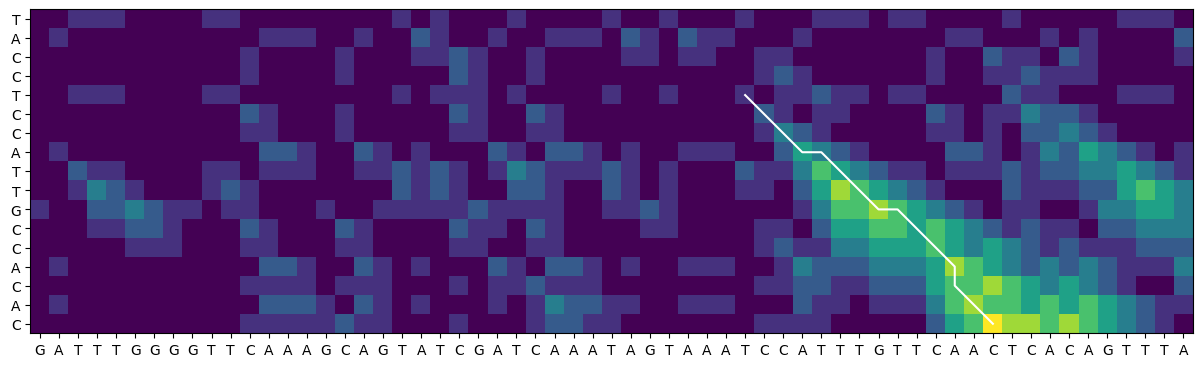

Read                      : TACGAAAGCACGGTAGGTTAATTAG
Mapping position (0-based): 12
Aligned read              : AAAGCACGGTA--GGTTAATTAG
Aligned read w/o gaps     : AAAGCACGGTAGGTTAATTAG
Number of clipped bases   : 4
Reference subsequence     : AAAGCAGTATCGATCAAATAG


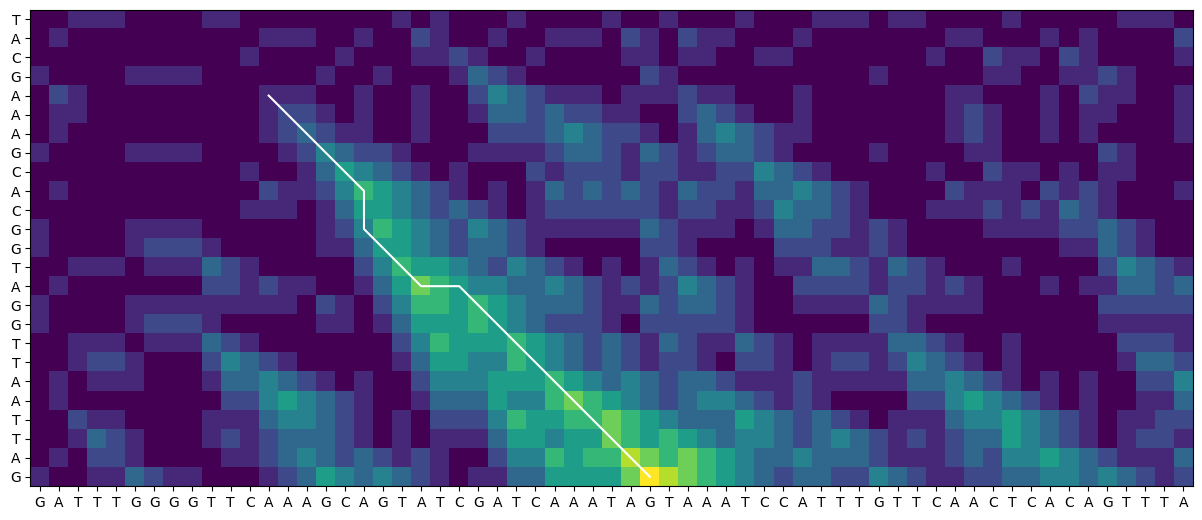

Read                      : CCGGGACAGGTAAGGTAATAACCAC
Mapping position (0-based): 23
Aligned read              : GA-CAGGTAAGGTAATAACCA
Aligned read w/o gaps     : GACAGGTAAGGTAATAACCA
Number of clipped bases   : 5
Reference subsequence     : GATCAAATAGTAAATCCA


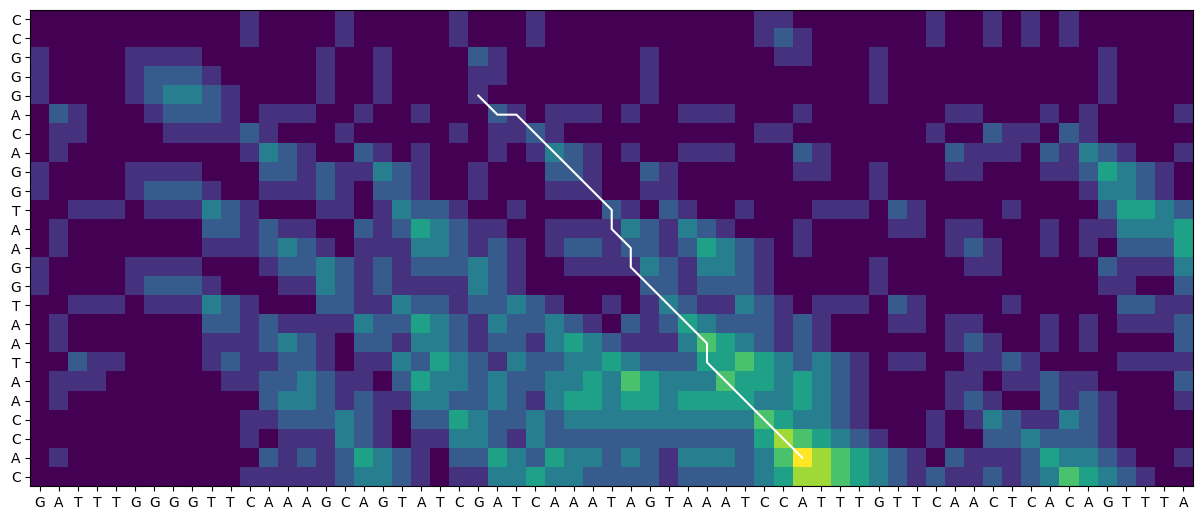

align: Multiple (3) possible traceback starts
align: Choosing traceback start by random: [19 22]
Read                      : TTGGGGTGCTTAGGGGTATGGC
Mapping position (0-based): 3
Aligned read              : TTGGGGTGCTTAGGGGTAT
Aligned read w/o gaps     : TTGGGGTGCTTAGGGGTAT
Number of clipped bases   : 3
Reference subsequence     : TTGGGGTTCAAAGCAGTAT


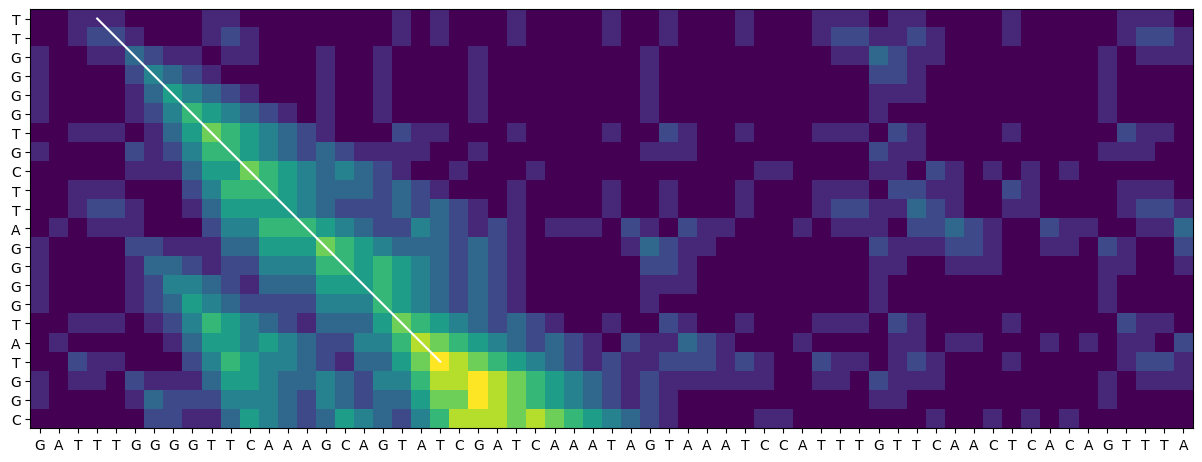

align: Multiple (3) possible traceback starts
align: Choosing traceback start by random: [19 57]
Read                      : GCATTCCTTCAAAACACGG
Mapping position (0-based): 39
Aligned read              : CATTCCTTCAAAACACGG
Aligned read w/o gaps     : CATTCCTTCAAAACACGG
Number of clipped bases   : 1
Reference subsequence     : CATTTGTTCAACTCACAG


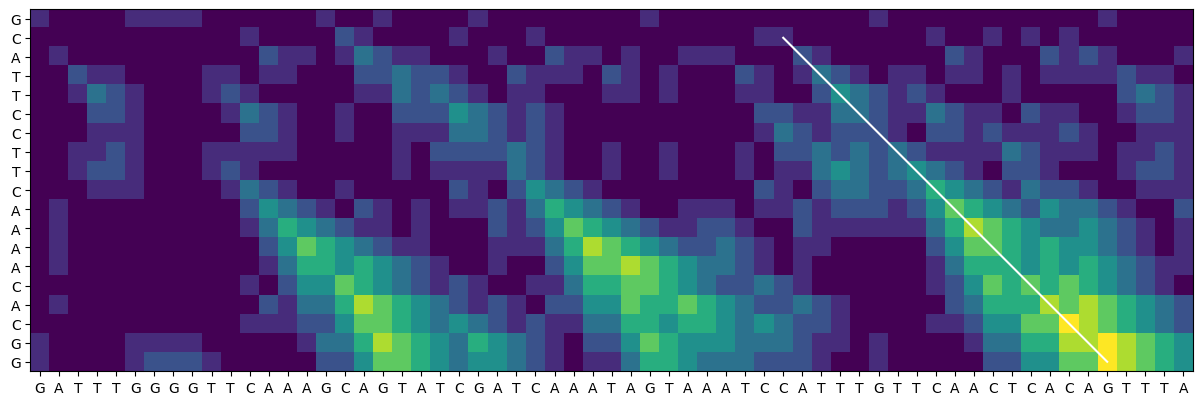

align: Multiple (2) possible traceback starts
align: Choosing traceback start by random: [14 29]
Read                      : CCAGTATCAGTCAACTCTTT
Mapping position (0-based): 16
Aligned read              : CAGTATC-AGTCAA
Aligned read w/o gaps     : CAGTATCAGTCAA
Number of clipped bases   : 7
Reference subsequence     : CAGTATCGATCAA


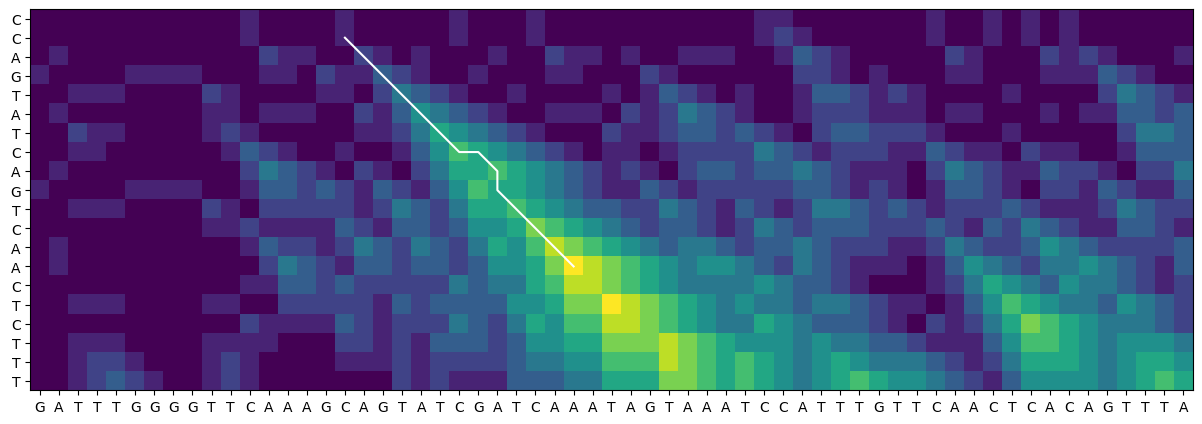

align: Multiple (2) possible traceback starts
align: Choosing traceback start by random: [19 31]
Read                      : AACCCAGTATCGATCTAATTGC
Mapping position (0-based): 16
Aligned read              : CAGTATCGATCTAAT
Aligned read w/o gaps     : CAGTATCGATCTAAT
Number of clipped bases   : 7
Reference subsequence     : CAGTATCGATCAAAT


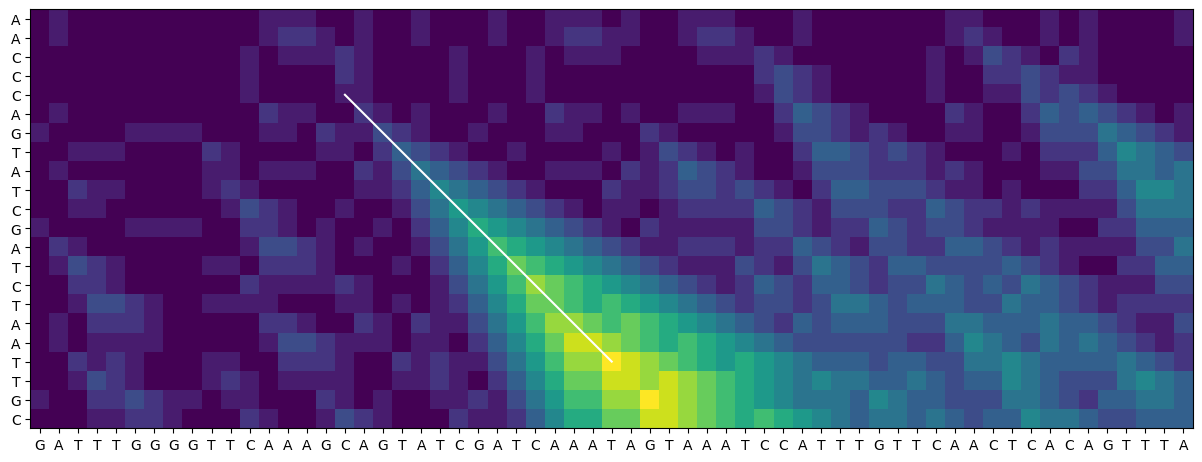

Read                      : TAATCTAAGTTTTTCAA
Mapping position (0-based): 35
Aligned read              : AATCTAAGTTT-TTCAA
Aligned read w/o gaps     : AATCTAAGTTTTTCAA
Number of clipped bases   : 1
Reference subsequence     : AATCCATTTGTTCAA


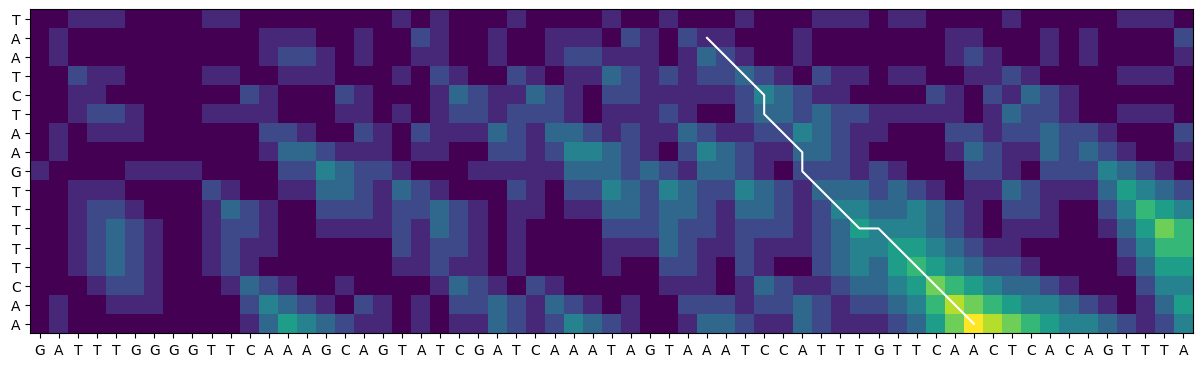

align: Multiple (3) possible traceback starts
align: Choosing traceback start by random: [17 26]
Read                      : TGCAAAGCAGAATTGATATCA
Mapping position (0-based): 11
Aligned read              : CAAAGCAGAATTGAT
Aligned read w/o gaps     : CAAAGCAGAATTGAT
Number of clipped bases   : 6
Reference subsequence     : CAAAGCAGTATCGAT


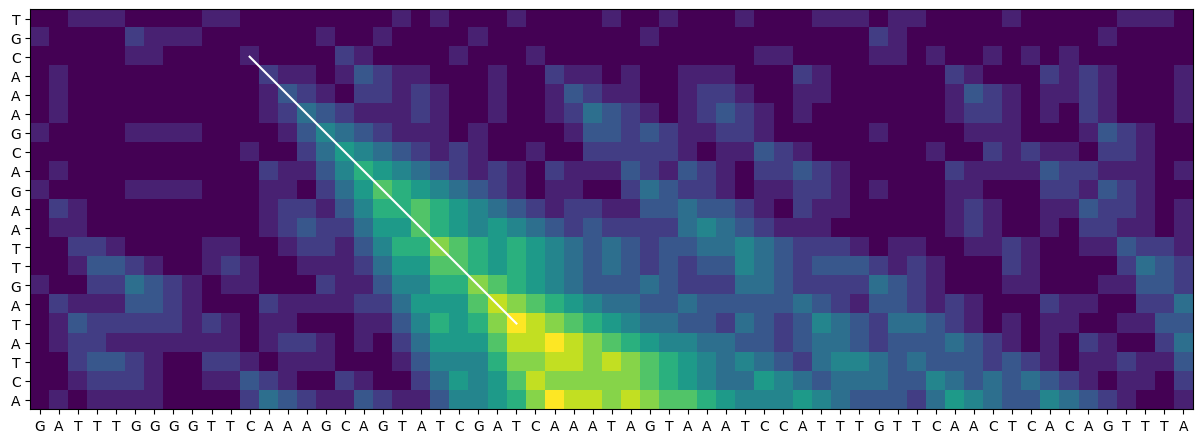

Read                      : CGAGTTCGACCCATCAA
Mapping position (0-based): 44
Aligned read              : GTTCGACCCATCA
Aligned read w/o gaps     : GTTCGACCCATCA
Number of clipped bases   : 4
Reference subsequence     : GTTCAACTCACA


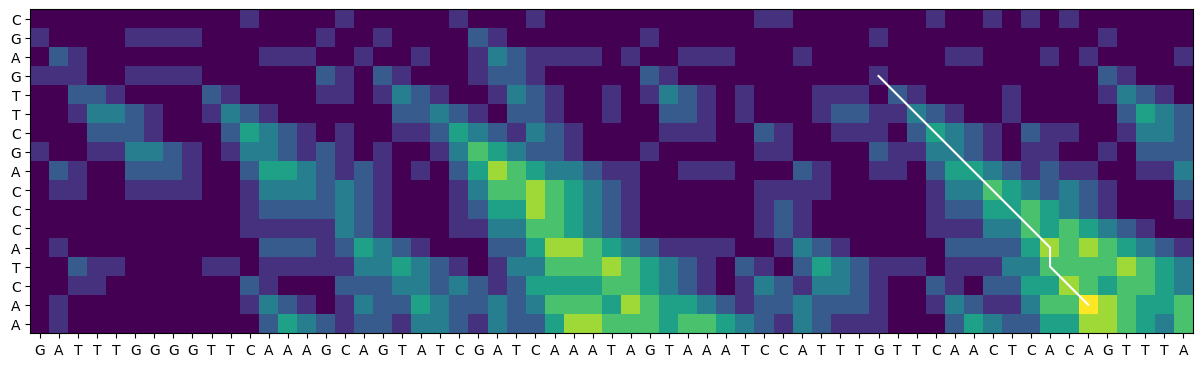

Read                      : GGTCAAAGTAGTAATGATCAAAC
Mapping position (0-based): 7
Aligned read              : GG-TCAAAGTAGTAAT-GATCAAA
Aligned read w/o gaps     : GGTCAAAGTAGTAATGATCAAA
Number of clipped bases   : 1
Reference subsequence     : GGTTCAAAGCAGTATCGATCAAA


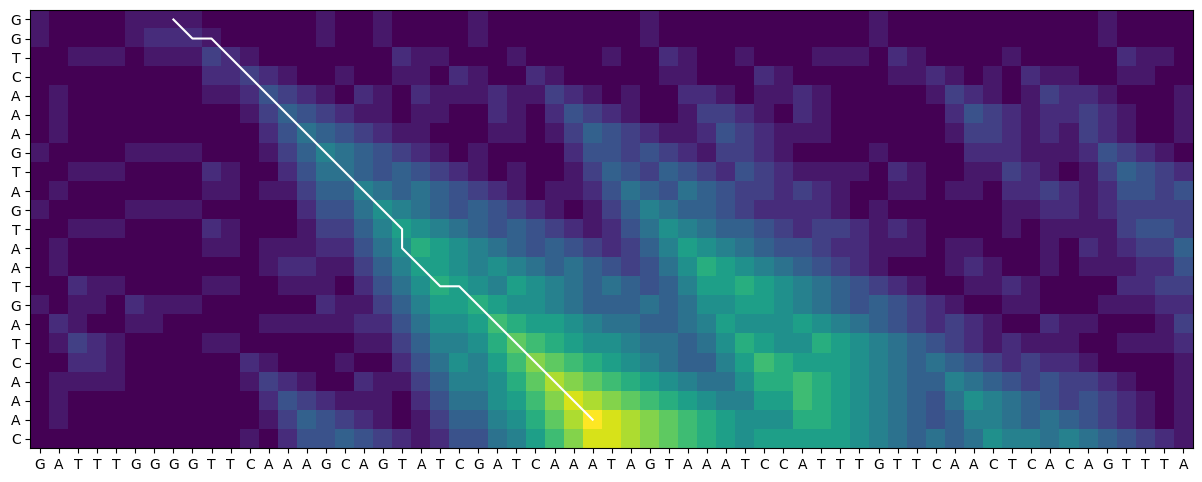

Read                      : CATATGTTCACGTCAC
Mapping position (0-based): 39
Aligned read              : CATATGTTC-ACGTCAC
Aligned read w/o gaps     : CATATGTTCACGTCAC
Number of clipped bases   : 0
Reference subsequence     : CATTTGTTCAACTCAC


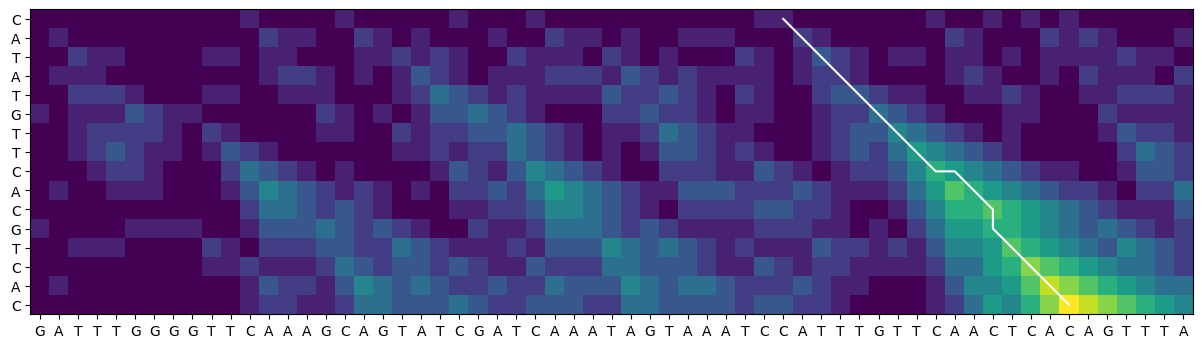

Read                      : TGACCACACACATTTCTCCAACT
Mapping position (0-based): 39
Aligned read              : CATTTCTCCAACT
Aligned read w/o gaps     : CATTTCTCCAACT
Number of clipped bases   : 10
Reference subsequence     : CATTTGTTCAACT


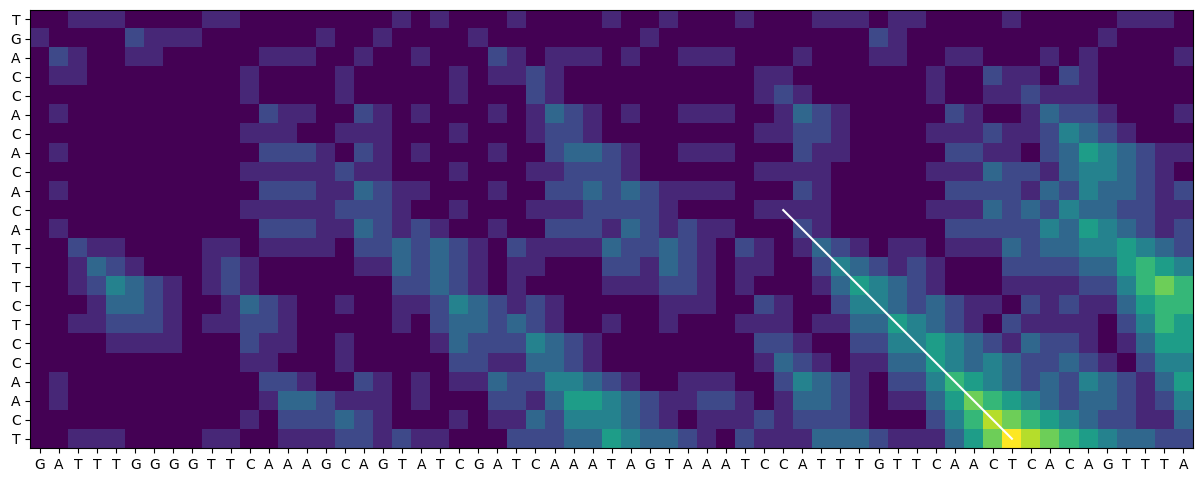

Read                      : GGGGATCAAGTCATTA
Mapping position (0-based): 5
Aligned read              : GGGGATC-AAGTCATTA
Aligned read w/o gaps     : GGGGATCAAGTCATTA
Number of clipped bases   : 0
Reference subsequence     : GGGGTTCAAAGCAGTA


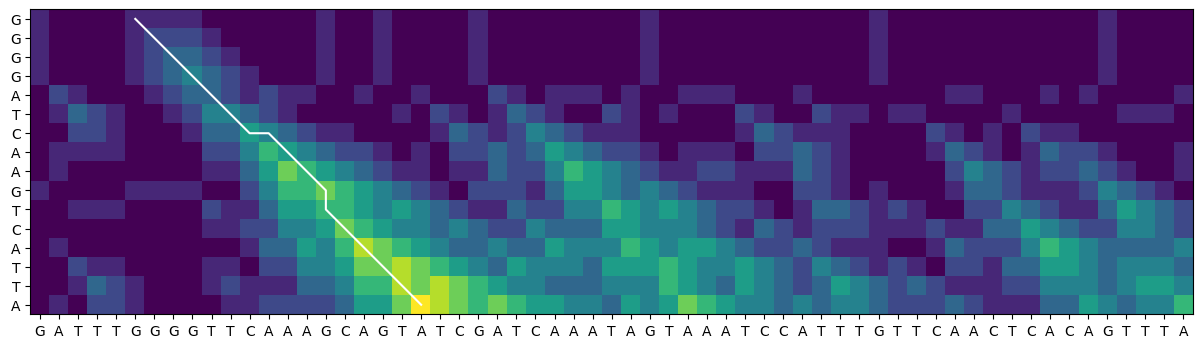

align: Multiple (2) possible traceback starts
align: Choosing traceback start by random: [22 41]
Read                      : TATAGACGAACGAGTAAATCTA
Mapping position (0-based): 19
Aligned read              : TATAGA-CGAACGAGTAAATCTA
Aligned read w/o gaps     : TATAGACGAACGAGTAAATCTA
Number of clipped bases   : 0
Reference subsequence     : TATCGATCAAATAGTAAATCCA


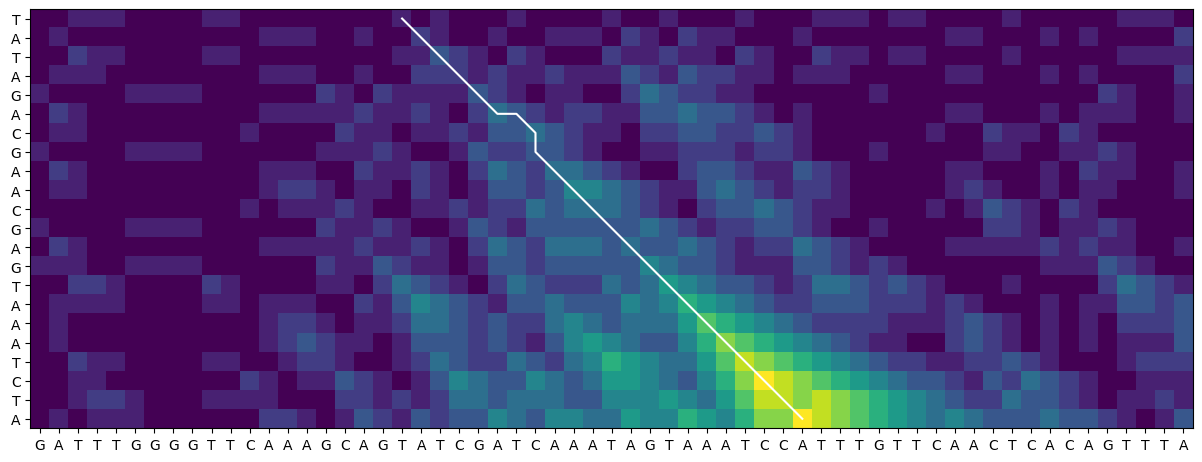

Read                      : GCAGTTCAATGCATTAT
Mapping position (0-based): 8
Aligned read              : GTTCAATGCATTAT
Aligned read w/o gaps     : GTTCAATGCATTAT
Number of clipped bases   : 3
Reference subsequence     : GTTCAAAGCAGTAT


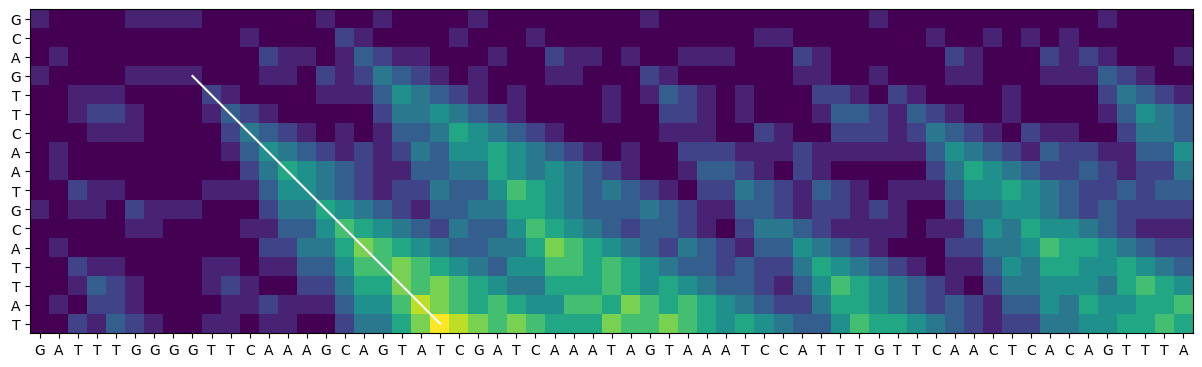

align: Multiple (3) possible traceback starts
align: Choosing traceback start by random: [24 28]
Read                      : GGTGTCCGACACAGGTTCGATCTA
Mapping position (0-based): 5
Aligned read              : GGTGTCCGACA-CAGGT-TCGATCTA
Aligned read w/o gaps     : GGTGTCCGACACAGGTTCGATCTA
Number of clipped bases   : 0
Reference subsequence     : GGGGTTCAAAGCAGTATCGATCA


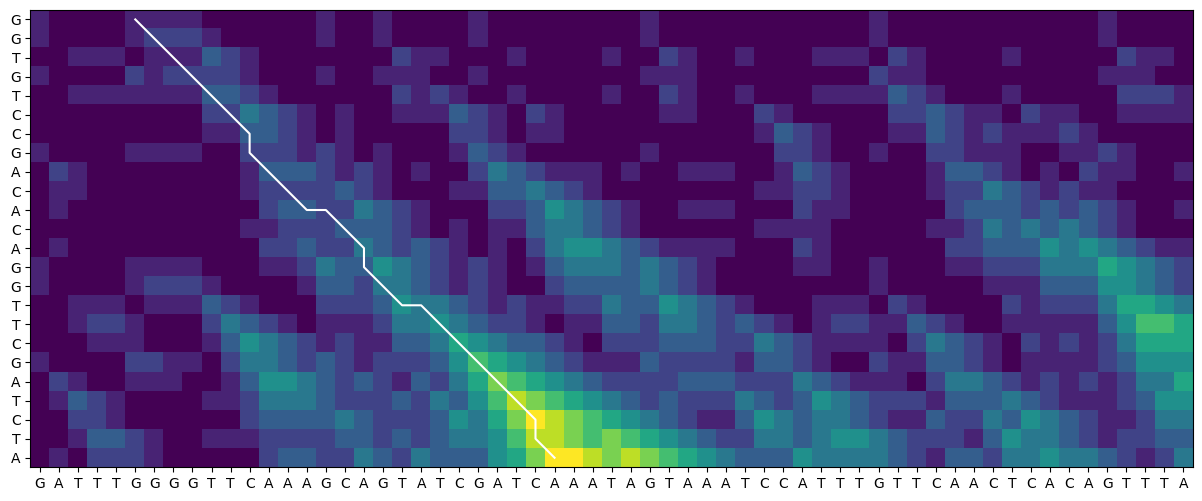

Read                      : AAATAATCTATTGGTTAA
Mapping position (0-based): 28
Aligned read              : AA-A-T-AATCTATTGGTT-AA
Aligned read w/o gaps     : AAATAATCTATTGGTTAA
Number of clipped bases   : 0
Reference subsequence     : AATAGTAAATCCATTTGTTCAA


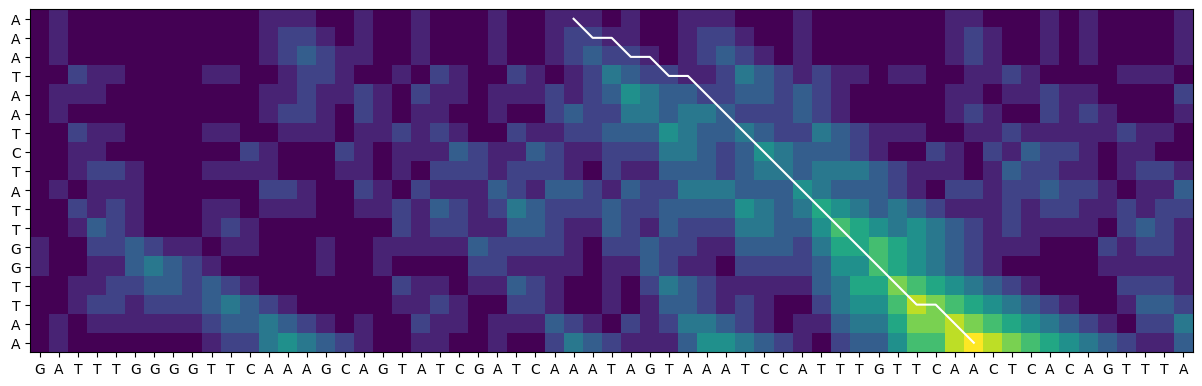

Read                      : GTATAAATAAAATACTA
Mapping position (0-based): 18
Aligned read              : GTATAAATAAAATACTA
Aligned read w/o gaps     : GTATAAATAAAATACTA
Number of clipped bases   : 0
Reference subsequence     : GTATCGATCAAATAGTA


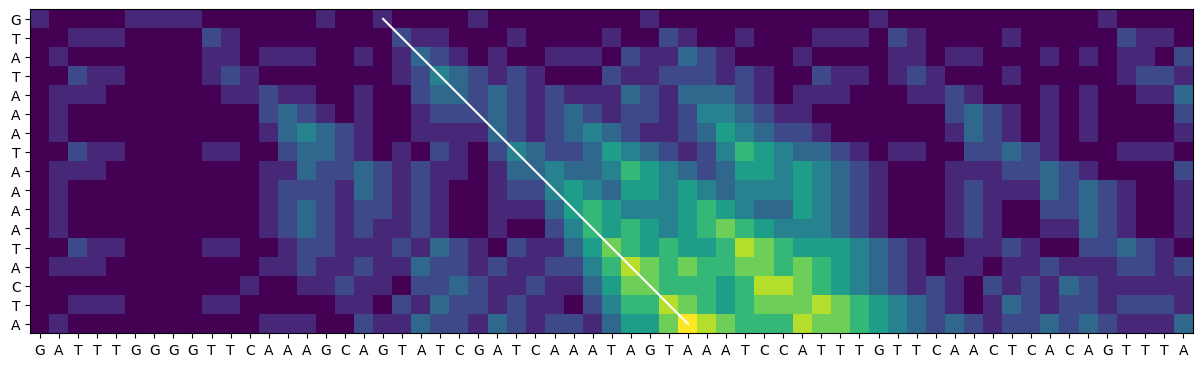

align: Multiple (5) possible traceback starts
align: Choosing traceback start by random: [11 43]
Read                      : GCCAATCCACTCGCGTGACC
Mapping position (0-based): 35
Aligned read              : AATCCACT
Aligned read w/o gaps     : AATCCACT
Number of clipped bases   : 12
Reference subsequence     : AATCCATT


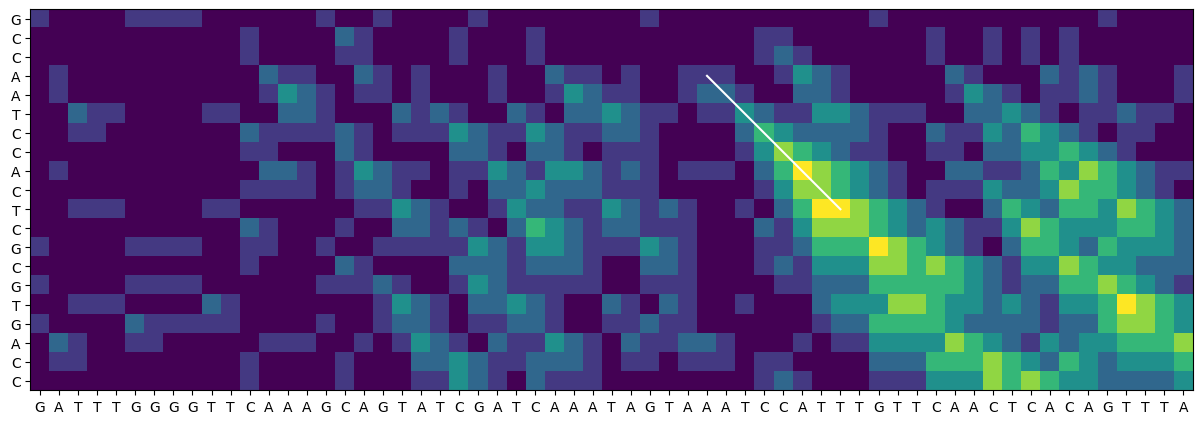

In [6]:
mapping_positions = []
aligned_reads = []

for read in noisy_reads:
    align = aln.make_align(mode="local")
    read_aln, ref_aln, warp_path_read, warp_path_ref, scoring_mat = align(
        seq_a=read, seq_b=reference_sequence
    )

    mapping_position = warp_path_ref[0]
    aligned_read = "".join(read_aln)
    mapping_positions.append(mapping_position)
    aligned_reads.append(aligned_read)

    print(f"Read                      : {read}")
    print(f"Mapping position (0-based): {mapping_position}")
    print(f"Aligned read              : {aligned_read}")
    aligned_read_without_gaps = list(filter(lambda elem: elem != "-", read_aln))
    print(f"Aligned read w/o gaps     : {''.join(aligned_read_without_gaps)}")
    print(f"Number of clipped bases   : {len(read) - len(aligned_read_without_gaps)}")
    print(
        f"Reference subsequence     : {reference_sequence[warp_path_ref[0] : (warp_path_ref[-1] + 1)]}"
    )

    plt.figure(figsize=[15, 8])
    plt.imshow(X=scoring_mat)
    plt.plot(warp_path_ref, warp_path_read, "w")
    plt.xticks(ticks=range(len(reference_sequence)), labels=reference_sequence)
    plt.yticks(ticks=range(len(read)), labels=read)
    plt.show()

We now have the following set of aligned reads:

In [7]:
print(f"Reference: {reference_sequence}")
for i, (pos, seq) in enumerate(zip(mapping_positions, aligned_reads)):
    print(f"Read {i:4}: {' ' * pos}{seq}")

Reference: GATTTGGGGTTCAAAGCAGTATCGATCAAATAGTAAATCCATTTGTTCAACTCACAGTTTA
Read    0:                                      TCCA-TTG-CCACAC
Read    1:             AAAGCACGGTA--GGTTAATTAG
Read    2:                        GA-CAGGTAAGGTAATAACCA
Read    3:    TTGGGGTGCTTAGGGGTAT
Read    4:                                        CATTCCTTCAAAACACGG
Read    5:                 CAGTATC-AGTCAA
Read    6:                 CAGTATCGATCTAAT
Read    7:                                    AATCTAAGTTT-TTCAA
Read    8:            CAAAGCAGAATTGAT
Read    9:                                             GTTCGACCCATCA
Read   10:        GG-TCAAAGTAGTAAT-GATCAAA
Read   11:                                        CATATGTTC-ACGTCAC
Read   12:                                        CATTTCTCCAACT
Read   13:      GGGGATC-AAGTCATTA
Read   14:                    TATAGA-CGAACGAGTAAATCTA
Read   15:         GTTCAATGCATTAT
Read   16:      GGTGTCCGACA-CAGGT-TCGATCTA
Read   17:                             AA-A-T-AATCTATTGGTT-AA

# Variant calling

Variant calling is a crucial step in analyzing DNA sequence data to identify differences or variations in the genetic code of individuals.
This process involves comparing an individual's DNA sequence (in the form of aligned reads) to a reference sequence to pinpoint variations such as single nucleotide polymorphisms (SNPs), insertions, deletions, and structural alterations.

While there exist many sophisticated variant calling algorithms such as [GATK](https://gatk.broadinstitute.org)'s [HaplotypeCaller](https://gatk.broadinstitute.org/hc/en-us/articles/360037225632-HaplotypeCaller), we will here focus on SNPs only and perform a simple majority voting per locus.

In [10]:
from collections import Counter

pileups = [[] for _ in range(len(reference_sequence))]
snps = {}

# Accumulate the pileups
for pos, seq in zip(mapping_positions, aligned_reads):
    for offset, _ in enumerate(seq):
        pileups[pos + offset].append(seq[offset])

# SNP calling via majority voting
print("POS   REF   MAJ   SNP   PILEUP")
for i, pileup in enumerate(pileups):
    majority_base = ""
    snp = "-"

    # Make a pileup string
    pileup = "".join(pileup)

    # We can only call variants for non-empty pileups
    if pileup:
        # Count the occurrences of each character in the pileup
        char_counts = Counter(pileup)
        # Find the most common character
        majority_base, _ = char_counts.most_common(n=1)[0]
    # No variant if the pileup is empty
    else:
        majority_base = "-"

    # Call it if it's a SNP
    if majority_base != "-" and majority_base != reference_sequence[i]:
        snp = majority_base
        snps[i] = snp

    print(f"{i:3}   {reference_sequence[i]:3}   {majority_base:3}   {snp:3}   {pileup}")

POS   REF   MAJ   SNP   PILEUP
  0   G     -     -     
  1   A     -     -     
  2   T     -     -     
  3   T     T     -     T
  4   T     T     -     T
  5   G     G     -     GGG
  6   G     G     -     GGG
  7   G     G     -     GGGT
  8   G     G     -     GGGGG
  9   T     T     -     T-ATT
 10   T     T     -     GTTTC
 11   C     C     -     CCCCCC
 12   A     A     -     ATAA-AG
 13   A     A     -     ATAAAAA
 14   A     A     -     AAAAATC
 15   G     G     -     GGGGGGA
 16   C     C     -     CGCCCTTC-
 17   A     A     -     AGAAAACAC
 18   G     G     -     CGGGGGATAG
 19   T     T     -     GTTTATTTTGT
 20   A     A     -     GAAAAATAAGA
 21   T     T     -     TTTTTAATTTT
 22   C     A     A     ACCTTA-A
 23   G     G     -     -G-GG-GTA
 24   A     A     -     -AAAAGACA
 25   T     G     G     G-GTTA-GT
 26   C     C     -     GCTCTCAA
 27   A     T     T     TACTCGTA
 28   A     A     -     TGAAAACAA
 29   A     A     -     AGAAAATAA
 30   T     A     A     ATTA

In [9]:
# List all SNPs
print("POS   SNP")
for pos, snp in snps.items():
    print(f"{pos:3}   {snp:3}")

POS   SNP
 22   A  
 25   G  
 27   T  
 30   A  
 32   A  
 33   G  
 34   G  
 50   A  
 51   C  
 55   C  
